# 6장. 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

# 1. 파이프 라인 이용

### 1) 전처리

1. 위스콘신 유방암 데이터셋 적재

In [82]:
#[0]: 샘플 고유 id /  [1]: 진단 결과(m=악성, b= 양성) / [2]~ 특징 실수값
import pandas as pd
df = pd.read_csv('wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [83]:
df.shape

(569, 32)

2) 데이터 x, y 할당 + 정수 인코딩

In [84]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values # feature [2]열~
y = df.loc[:, 1].values #label [1] 열

le = LabelEncoder()
y = le.fit_transform(y) #label 정수로 인코딩
le.classes_

array(['B', 'M'], dtype=object)

In [85]:
#인코딩 결과 체크 M=1 B=0
le.transform(['M', 'B']) 

array([1, 0])

3) 데이터 split

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

### 2) 파이프라인으로 변환기와 추정기 연결하기

3개의 객체를 파이프 라인 하나로 묶어서 할당

- StandardScaler: 특성 표준화
- PCA: 주성분 분석(특성 추출)
- LogisticRegression: 로지스틱 회귀(선형 분류기) 

make_pipeline의 중간 단계(변환기)의 횟수 제한 없음 =>하지만 마지막 파라미터는 반드시 "추정기"여야함

.predict => 변환기+추정기의 예측 성능을 출력

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#파이프 라인 생성
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1))

#파이프 라인에 데이터 넣어=> 전처리+학습
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


# 2. k-겹 교차 검증을 사용한 모델 성능 평가

### 1) k-겹 교차 검증 (구현)

In [88]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10, random_state=1,shuffle=True).split(X_train, y_train)

scores = []

#총 k번 반복=> k개의 모델과 성능 얻음
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train]) # 앞에서 make_pipeline으로 정의한 파이프 라인으로 학습됨
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score)) 
    
# 평균 성능 계산
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) 

폴드:  1, 클래스 분포: [256 153], 정확도: 0.913
폴드:  2, 클래스 분포: [256 153], 정확도: 1.000
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.978
폴드:  5, 클래스 분포: [256 153], 정확도: 0.870
폴드:  6, 클래스 분포: [257 153], 정확도: 0.933
폴드:  7, 클래스 분포: [257 153], 정확도: 0.956
폴드:  8, 클래스 분포: [257 153], 정확도: 0.978
폴드:  9, 클래스 분포: [257 153], 정확도: 0.978
폴드: 10, 클래스 분포: [257 153], 정확도: 0.911

CV 정확도: 0.947 +/- 0.038


### 2) 계층별 k-겹 교차 검증 (사이킷런)

cross_val_score(estimator=파이프라인 추정기,
                         X=X_train,
                         y=y_train,
                         cv=k폴드 갯수,
                         n_jobs=cup갯수 지정)

- n_job=2 : 두개의 cpu코어가 교차 검증을 10회씩 분할 함
- n_job=-1 : 모든 cpu코어가 병렬처리함

In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


# 3. 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 1) 학습 곡선

In [90]:
import matplotlib.pyplot as plt

learning_curve : 학습 곡선 생성 함수
- 샘플 크기에 따른-> 계층적 k-겹 교차검증-> 평균 훈련 정확도, 교차 검증 정확도, 표준편차
- train_sizes 샘플 크기 범위 지정

분석 결과
- train 샘플이 250개 이상일 때 잘 작동
- 250개 미만은 훈련 데이터와 검증데이터가 차이남 => 과대 적합의 증거

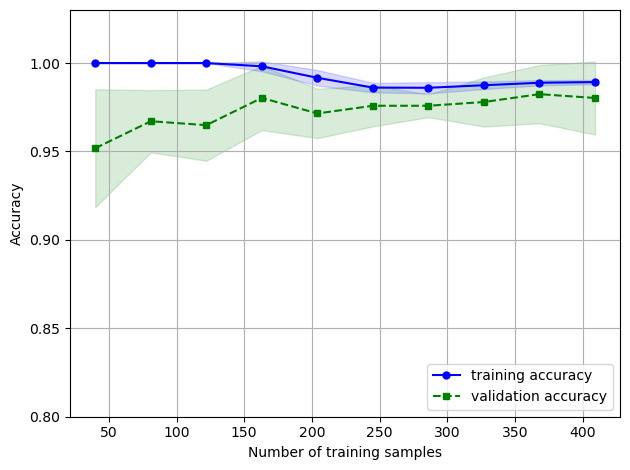

In [108]:
from sklearn.model_selection import learning_curve

#파이프 라인 생성: 표준화, 로지스틱 회귀(l2규제)
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', 
                                           penalty='l2', 
                                           random_state=1))

#학습 곡선 생성
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# train 평균성능(정확도)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')
# train 평균성능의 표준편차 -> 추정 분산
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


#test 평균성능(정확도)
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')
# test 평균성능의 표준편차 -> 추정 분산
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### 2) 검증 곡선

validation_curve: 검증 곡선 생성 함수
- 파라미터 값에 따른 -> 계층적 k-겹 교차검증-> 평균 훈련 정확도, 교차 검증 정확도, 표준편차
- param_name = 함수 안에 평가하고 싶은 파라미터 지정 
- param_range = 파라미터 범위 지정


해당 예제는 로지스틱함수의 규제 파라미터 c값이 바뀜에 따른 검증 곡선이다.
- 분석 결과: 규제강도 높음(c값 작음)-> 과소 적합 / c값 커짐-> 과대 적합
- c는 0.01 ~ 0.1사이가 적합하다 

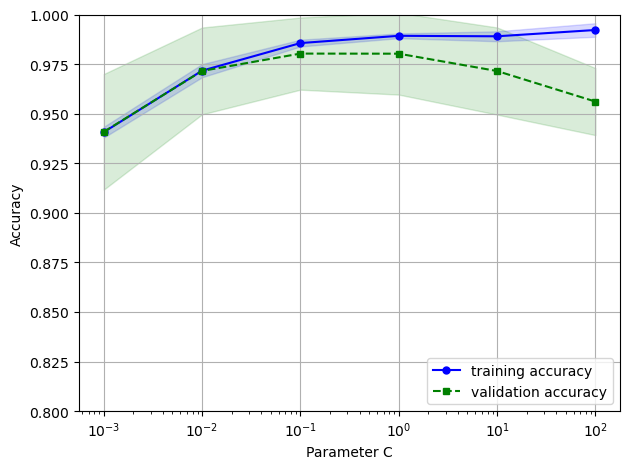

In [92]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#train acc, 표준편차
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

#test acc, 표준편차
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.00])
plt.tight_layout()
plt.show()

# 4. 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

### 1) 그리드 서치를 사용한 하이퍼파라미터 튜닝

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [94]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


### 2) 중첩 교차 검증을 사용한 알고리즘 선택

In [95]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [96]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV 정확도: 0.934 +/- 0.016


# 5. 다른 성능 평가 지표

## 오차 행렬

In [97]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


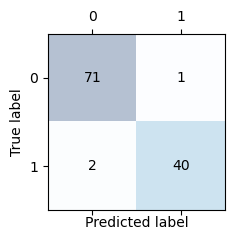

In [98]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

## 분류 모델의 정밀도와 재현율 최적화

In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


In [100]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## ROC 곡선 그리기

C:\Users\jsm36\AppData\Local\Temp\ipykernel_25308\65818882.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
C:\Users\jsm36\AppData\Local\Temp\ipykernel_25308\65818882.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
C:\Users\jsm36\AppData\Local\Temp\ipykernel_25308\65818882.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


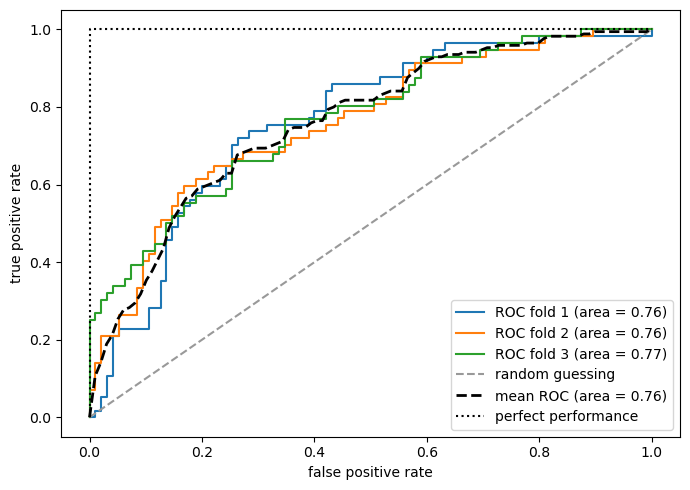

In [101]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear',
                                           penalty='l2', 
                                           random_state=1, 
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3, 
                          random_state=1, shuffle=True).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## 다중 분류의 성능 지표

In [102]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

## 불균형한 클래스 다루기

In [103]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [104]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [105]:
from sklearn.utils import resample

print('샘플링하기 전의 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링한 후의 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전의 클래스 1의 샘플 개수: 40
샘플링한 후의 클래스 1의 샘플 개수: 357


In [106]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [107]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0